### Week 11 ANTM Test

### **Import Libraries**

In [1]:
# import needed libraries
import numpy as np
from numpy import loadtxt
from pandas_datareader import data, wb
import datetime
import holidays
from dateutil.relativedelta import relativedelta
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import seaborn as sns
import itertools
from itertools import chain
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### **Data Preprocessing**

In [4]:
def data_preparation(path):
    factor_df = pd.read_csv(path)
    # remove non-rank columns 
    columns = factor_df.columns.drop(['End of Month', 'PERMNO', 'GVKEY', 'Point-in-time CUSIP', 'Point-in-time Ticker', 'Point-in-time Name', 'Last Known CUSIP', 'Last Known Ticker', 'Last Known Name'])
    factor_df = factor_df[columns]
    
    # Convert CalendarDate into datatime format
    factor_df['Date'] =  pd.to_datetime(factor_df['Calendar Date'], format='%Y%m%d')
    factor_df = factor_df.drop(['Calendar Date'], axis=1)
    # create a new dataframe with 'CalendarDate' column as index
    factor_df = factor_df.set_index('Date')
    
    # handling missing data
    factor_df[factor_df=='.'] = pd.np.nan 
    factor_df = factor_df.astype(float)
    
    # remove columns contains nan
    factor_df = factor_df.dropna(axis=1, how='any')
      
    return factor_df
    
ANTM_tech_factor_df = data_preparation('tech_factor_data/ANTM_tech_inputs_daily_quintile_ranks_s2003.csv')
ANTM_tech_factor_df.head()

,One-Week Daily Price Trend,One-Month Daily Price Trend,Three-Month Daily Price Trend,Nine-Month Daily Price Trend,Nine-Month Daily Return Skewness,Nine-Month Share of Days Outperforming,Average Daily Share Turnover,One-Month Change in Average Daily Share Turnover,Stochastic Oscillator,Relative Strength Index,...,Arbitrage Risk,One-Month Change in Arbitrage Risk,Daily Media Sentiment Indicator,Sector ETF Flows-to-Market Capitalization,Downside Risk (Measured Over the Trailing Three Months),Downside Risk (Measured Over the Trailing Six Months),Downside Risk (Measured Over the Trailing Nine Months),Downside Risk (Measured Over the Trailing Twelve Months),Change in Downside Risk (Measured Over the Trailing Twelve Months),Interaction of Supernovas and Nine-Month Price Trend
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,3.0,1.0,5.0,1.0,1.0,2.0,5.0,5.0,4.0,2.0,...,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0
2003-01-03,4.0,1.0,5.0,2.0,1.0,3.0,5.0,5.0,4.0,2.0,...,4.0,4.0,1.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0
2003-01-06,4.0,3.0,5.0,1.0,1.0,3.0,5.0,5.0,2.0,1.0,...,4.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0
2003-01-07,5.0,4.0,5.0,2.0,1.0,3.0,5.0,5.0,1.0,1.0,...,4.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0
2003-01-08,5.0,4.0,5.0,2.0,1.0,3.0,5.0,5.0,1.0,1.0,...,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0


In [5]:
ANTM_tech_factor_df.columns

Index(['One-Week Daily Price Trend', 'One-Month Daily Price Trend',
       'Three-Month Daily Price Trend', 'Nine-Month Daily Price Trend',
       'Nine-Month Daily Return Skewness',
       'Nine-Month Share of Days Outperforming',
       'Average Daily Share Turnover',
       'One-Month Change in Average Daily Share Turnover',
       'Stochastic Oscillator', 'Relative Strength Index', 'Bollinger Band',
       'MACD Signal', 'Technical Indicator', 'Arbitrage Risk',
       'One-Month Change in Arbitrage Risk', 'Daily Media Sentiment Indicator',
       'Sector ETF Flows-to-Market Capitalization',
       'Downside Risk (Measured Over the Trailing Three Months)',
       'Downside Risk (Measured Over the Trailing Six Months)',
       'Downside Risk (Measured Over the Trailing Nine Months)',
       'Downside Risk (Measured Over the Trailing Twelve Months)',
       'Change in Downside Risk (Measured Over the Trailing Twelve Months)',
       'Interaction of Supernovas and Nine-Month Price Tren

### **Selected Technical Factors**

In [6]:
sns.set_context('notebook', font_scale=2)

def plot_one_column(df, column_name):
    plt.style.use('ggplot')
    fig, gx = plt.subplots(figsize = (40,10))
    gx.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    gx.plot(df.index, df[column_name], color='blue', label=column_name)
    gx.set_xlabel('Dates',size=40, fontsize=40)
#     gx.set_ylabel('Quintile Rank', fontsize=20)
    gx.set_title(column_name, size=40)
    # other parameters
    gx.grid(True)

### **Function to Generate real-time labels**

In [7]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

# function to return the date of n bussiness days before the test date 
def n_business_day_before(test_date, n):
    last_day = test_date
    for _ in range(n):
        last_day = last_day - ONE_DAY
        while last_day.weekday() in holidays.WEEKEND or last_day in HOLIDAYS_US:
            last_day -= ONE_DAY
    return last_day 

def up_down_threshold(df, train_start_date, test_date, pred_day):
    '''
    df: dataframe contains ReturnNDays column
    '''   
    train_end_date = n_business_day_before(test_date, pred_day)
    dataset_mask = (df.index>=train_start_date) & (df.index<=train_end_date)
    return_list = df['Return{}Days'.format(pred_day)].loc[dataset_mask].tolist()
    sorted_return_list = sorted(return_list, key=float)
#     print(sorted_return_list)
    down_thres_index = int(len(sorted_return_list)/3 + 1)
    up_thres_index = down_thres_index * 2 
    down_thres, up_thres = sorted_return_list[down_thres_index], sorted_return_list[up_thres_index]
    return down_thres, up_thres

def generate_NDayReturn(factor_df, ticker_name, start_date, end_date, pred_day):
    price_df = data.DataReader(ticker_name, 'yahoo', start_date, end_date)
    price_df = price_df[['Adj Close']]
    df = pd.merge(factor_df, price_df, on='Date')

    # obtain n day return percent in the future 
    df['Return{}Days'.format(pred_day)] = df['Adj Close'].pct_change(pred_day).shift(-pred_day)  
    # remove the last n days NaN returns
    df = df[:-pred_day]
    
    # remove 'Adj Close' columns
    columns = df.columns.drop(['Adj Close'])
    df = df[columns]
    
    return df

# function to generate dir labels real time based on the shifting input training window balance 
def generate_labels_real_time(df, pred_day, train_start, test_date):
     
    # calculate training set up/down thresholds
    down_thres, up_thres = up_down_threshold(df, train_start, test_date, pred_day)
    
    # Obtain 'DirNDays' column based on thresholds
    df['Dir{}Days'.format(pred_day)] = 'neu'
    df.loc[df['Return{}Days'.format(pred_day)]>up_thres, 'Dir{}Days'.format(pred_day)] = 'pos'
    df.loc[df['Return{}Days'.format(pred_day)]<down_thres, 'Dir{}Days'.format(pred_day)] = 'neg'

    # remove 'Return5Days' and 'Adj Close' columns
    columns = df.columns.drop(['Return{}Days'.format(pred_day)])
    df = df[columns]

    #Creating the dependent variable class
    # 'neg': 0, 'neu': 1, 'pos': 2
    le = LabelEncoder()
    df['Dir{}Days'.format(pred_day)] = le.fit_transform(df['Dir{}Days'.format(pred_day)])
    df = df.astype(float)
    df = df.astype({'Dir{}Days'.format(pred_day): int})
    
    return df 

### **Function for Model Building**

In [8]:
def model_testing(df, test_date_start, history_window, pred_day, model_name):
    
    test_dates = df.loc[test_date_start:].index.tolist()
    y_true = []
    y_pred = []
    
    # select ml model 
    if model_name == 'LR':
        model = LogisticRegression()
        
#         model = LogisticRegression(penalty='l1', C=10, solver='liblinear')
    elif model_name == 'NB':
        model = GaussianNB()
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators = 8, criterion = 'entropy', random_state = 42)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=12)
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=200,algorithm="SAMME.R", learning_rate=0.1, random_state=0)
    
    for test_date in test_dates:
        # create training and testing set
        train_start = test_date - history_window
#         print('test_date: {t} \t train_end: {e}'.format(t=test_date, e=train_end))
        real_time_df = generate_labels_real_time(df, pred_day, train_start, test_date)
        
        # dataset will include test_date data also
        dataset = real_time_df.loc[train_start:test_date]
        # training set last label should be current test_date 
        train_set = dataset[:-pred_day].values
        test_set = dataset.loc[test_date].values
        X_train, y_train = train_set[:, :-1], train_set[:, -1]
        X_test, y_test = test_set[:-1].reshape(1,-1), test_set[-1]
        
        # training and testing 
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        
#     label_plot(real_time_df,'Dir{}Days Distribution'.format(pred_day), train_start, test_date, pred_day)
    
    y_true, y_pred = np.array(y_true), np.array(y_pred).transpose().flatten()

    return y_true, y_pred, test_dates

#### **Function for Model Performance Evaluation**

In [9]:
def model_performance(y_test, y_pred, model_name):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1_wght = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    performance_df = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1wght':  f1_wght, 'F1micro': f1_micro}, index=[0])
    return performance_df 

def error_distance_count(y_test, y_pred):
    error_distance = np.absolute(y_test - y_pred)
    unique, counts = np.unique(error_distance, return_counts=True)
    counts = counts / len(y_test)
    error_dic = dict(zip(unique, counts))
    return error_dic 

def plot_error_distance(y_test, y_pred, title):
    #========== plot setting=========== 
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-darkgrid')
    
    error_dic = error_distance_count(y_test, y_pred)
    plt.xlabel('Error Distance')
    plt.ylabel('Error Rate')
    plt.title(title, loc='center')
    plt.bar(list(error_dic.keys()), error_dic.values(), color='g')
    plt.show()    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    #========== plot setting=========== 
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-white')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks()).astype(str))
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot predictions vs observations
def plot_pred_perform(y_true, y_pred, test_dates, title):
    #========== plot setting=========== 
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.5)
    plt.style.use('seaborn-whitegrid')
    plt.scatter(test_dates, y_true,s=50, c='r', alpha=0.8, label='True Dir', edgecolor='none')
    plt.scatter(test_dates, y_pred, s=50, c='b', alpha=0.3, label='Predict Dir', edgecolor='none')
    plt.title(title)
    plt.ylabel('Direction Label')
#     plt.xticks(rotation=45)
    plt.xlabel('Date')
#     plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
# function return univariate distributions of Dir5Days
def label_plot(df, title, start_date, end_date, pred_day):
    dataset_mask = (df.index>start_date) & (df.index<end_date)
#     date_start = test_date_start - history_window
#     dataset_mask = (df.index>date_start) 
    dataset = df.loc[dataset_mask]
    plt.rcParams['figure.figsize'] = (10, 5)
    sns.set_context('notebook', font_scale=1.5)
    plt.style.use('seaborn-darkgrid')
    sns.countplot(dataset['Dir{}Days'.format(pred_day)],palette='Set1')
    plt.title(title, loc='center')
    plt.tight_layout()
    plt.show()
    
def model_evalutation(y_true, y_pred, test_dates, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(ticker_name))
    plot_error_distance(y_true, y_pred, 'Error Performance for {}'.format(model_name))
    performance = model_performance(y_true, y_pred, model_name)
    plot_pred_perform(y_true, y_pred, test_dates, 'Prediction Performance for {}'.format(model_name))
    print(performance)
    return performance

#### **Model Test**

In [10]:
var_thres = 0.2
def variance_feature_selection(factor_df, var_thres):
    selector = VarianceThreshold(var_thres)
    fit = selector.fit_transform(factor_df)
    dfvariances = pd.DataFrame(selector.variances_)
    dfcolumns = pd.DataFrame(factor_df.columns)
    #concat two dataframes for better visualization 
    featureVariances = pd.concat([dfcolumns,dfvariances],axis=1)
    featureVariances.columns = ['Factor','Variance']  #naming the dataframe columns
    print(featureVariances.nlargest(34,'Variance'))  #print 10 best features
    
    
    return factor_df[factor_df.columns[selector.get_support(indices=True)]]
var_DAL_tech_factor_df = variance_feature_selection(ANTM_tech_factor_df, var_thres)

                                               Factor  Variance
7    One-Month Change in Average Daily Share Turnover  2.207252
8                               Stochastic Oscillator  2.114480
11                                        MACD Signal  2.101542
9                             Relative Strength Index  2.090490
0                          One-Week Daily Price Trend  2.072548
12                                Technical Indicator  2.057921
1                         One-Month Daily Price Trend  2.003844
21  Change in Downside Risk (Measured Over the Tra...  2.002492
16          Sector ETF Flows-to-Market Capitalization  1.962403
14                 One-Month Change in Arbitrage Risk  1.955578
3                        Nine-Month Daily Price Trend  1.944945
2                       Three-Month Daily Price Trend  1.940507
15                    Daily Media Sentiment Indicator  1.872466
4                    Nine-Month Daily Return Skewness  1.514290
5              Nine-Month Share of Days 

In [11]:
for factor in ANTM_tech_factor_df.columns:
    print(factor)

One-Week Daily Price Trend
One-Month Daily Price Trend
Three-Month Daily Price Trend
Nine-Month Daily Price Trend
Nine-Month Daily Return Skewness
Nine-Month Share of Days Outperforming
Average Daily Share Turnover
One-Month Change in Average Daily Share Turnover
Stochastic Oscillator
Relative Strength Index
Bollinger Band
MACD Signal
Technical Indicator
Arbitrage Risk
One-Month Change in Arbitrage Risk
Daily Media Sentiment Indicator
Sector ETF Flows-to-Market Capitalization
Downside Risk (Measured Over the Trailing Three Months)
Downside Risk (Measured Over the Trailing Six Months)
Downside Risk (Measured Over the Trailing Nine Months)
Downside Risk (Measured Over the Trailing Twelve Months)
Change in Downside Risk (Measured Over the Trailing Twelve Months)
Interaction of Supernovas and Nine-Month Price Trend


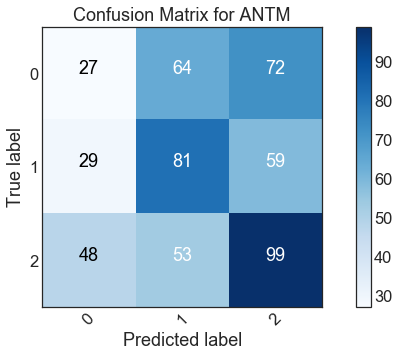

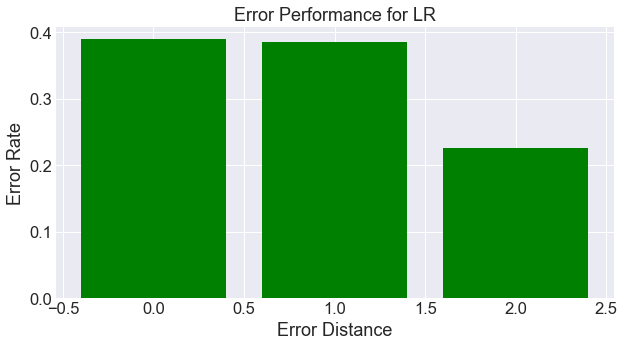

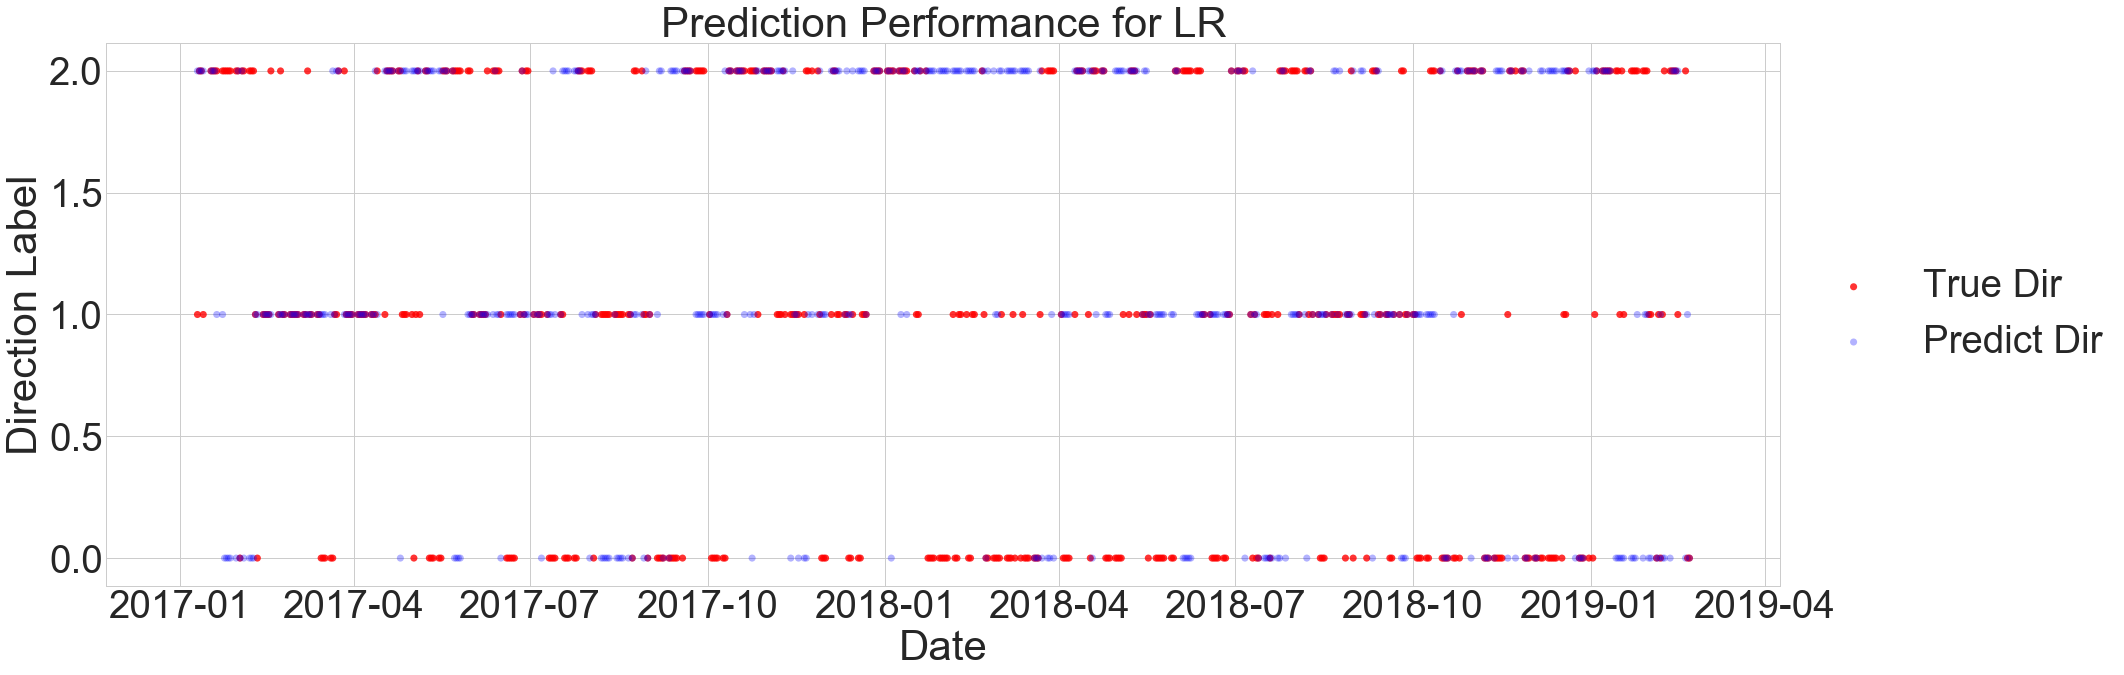

  Model  Accuracy  Precision    Recall    F1wght   F1micro
0    LR  0.389098   0.371317  0.389098  0.375298  0.389098


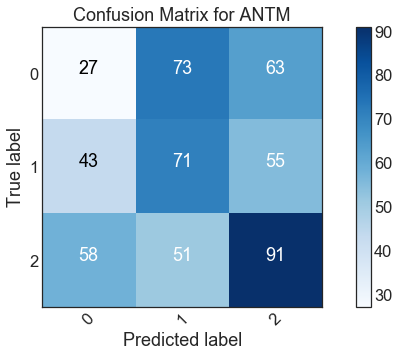

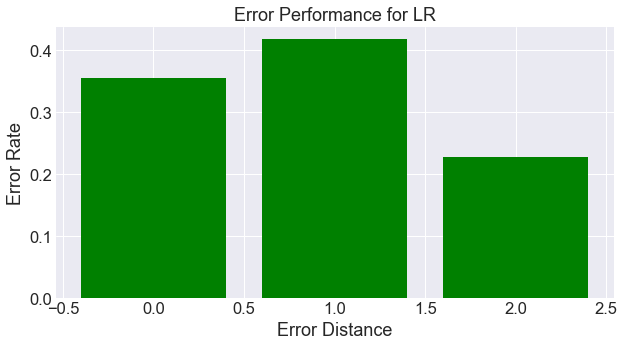

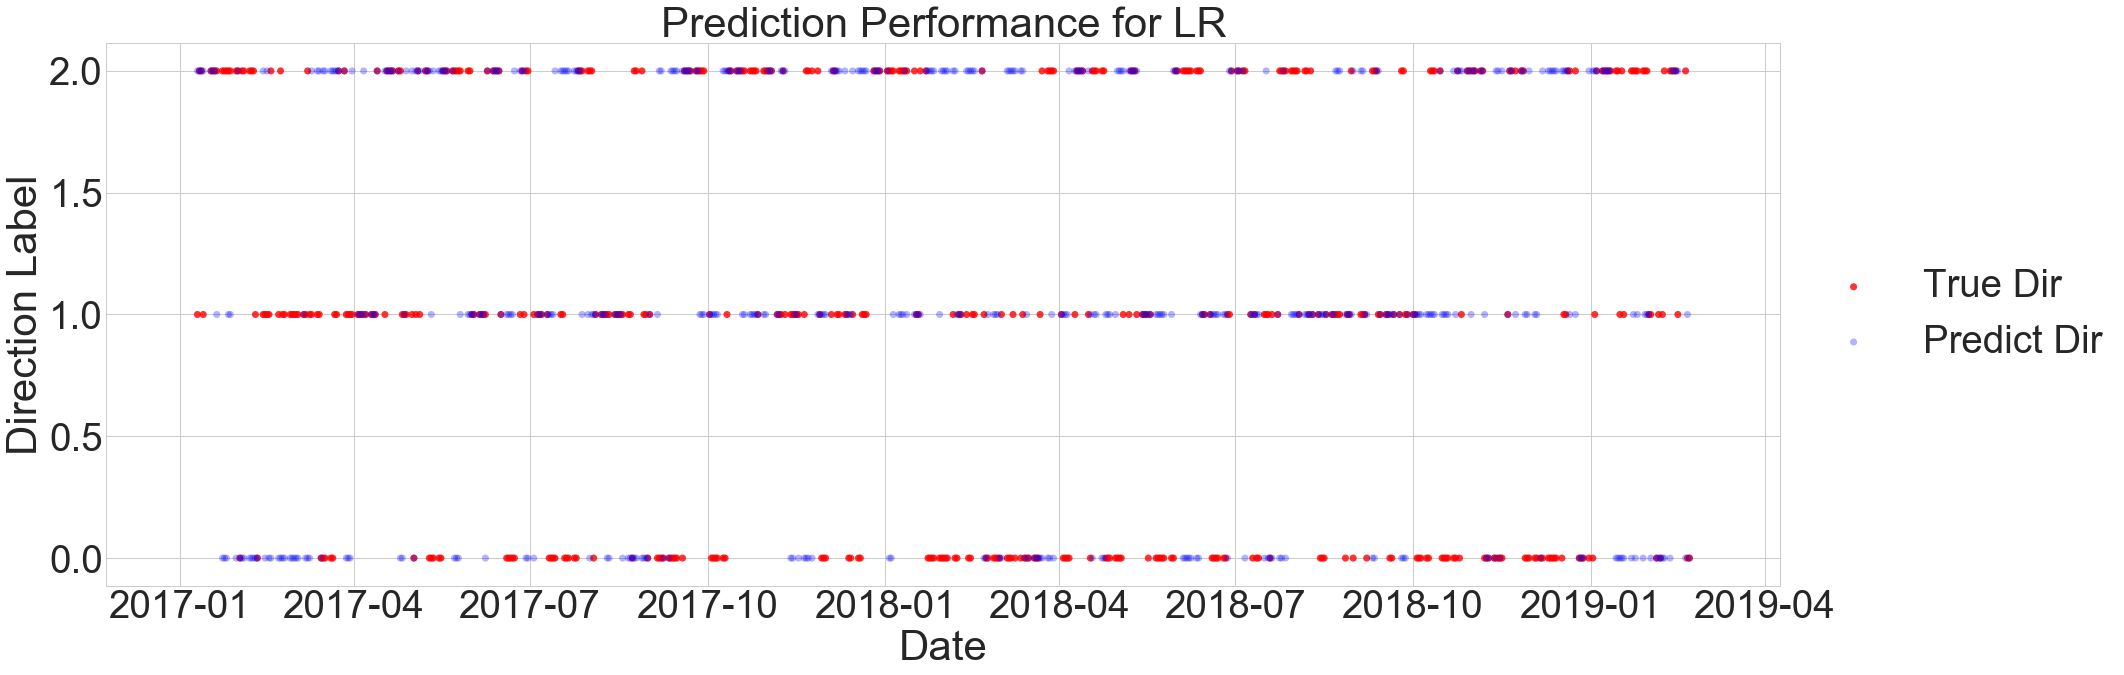

  Model  Accuracy  Precision    Recall    F1wght   F1micro
0    LR  0.355263    0.34398  0.355263  0.348071  0.355263


In [17]:
start_date = datetime.datetime(2003, 1, 2)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "ANTM"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=2) # training history window 
MODEL_NAME = 'LR'

selected_ANTM_tech_news_factors = ANTM_tech_factor_df[['One-Week Daily Price Trend', 'Relative Strength Index', 'MACD Signal', 
                                                    'Technical Indicator', 'One-Month Change in Average Daily Share Turnover', 
                                                      'Daily Media Sentiment Indicator']]

selected_ANTM_tech_factors = ANTM_tech_factor_df[['One-Week Daily Price Trend', 'Relative Strength Index', 'MACD Signal', 
                                                    'Technical Indicator', 'One-Month Change in Average Daily Share Turnover']]



ANTM_tech_df = generate_NDayReturn(selected_ANTM_tech_factors, ticker_name, start_date, end_date, pred_day)
ANTM_tech_news_df = generate_NDayReturn(selected_ANTM_tech_news_factors, ticker_name, start_date, end_date, pred_day)

y_true, y_pred_tech, test_dates = model_testing(ANTM_tech_df, test_date_start, history_window, pred_day, MODEL_NAME)
y_true, y_pred_news, test_dates = model_testing(ANTM_tech_news_df, test_date_start, history_window, pred_day, MODEL_NAME)


perform_without_news = model_performance(y_true, y_pred_tech, 'without news')
perform_with_news =model_performance(y_true, y_pred_news, 'with news')
result = pd.concat([perform_without_news, perform_with_news])
result

performance_with_news = model_evalutation(y_true, y_pred_news, test_dates, MODEL_NAME)
performance_without_news = model_evalutation(y_true, y_pred_tech, test_dates, MODEL_NAME)

In [18]:
result

,Model,Accuracy,Precision,Recall,F1wght,F1micro
0,without news,0.355263,0.343980,0.355263,0.348071,0.355263
0,with news,0.389098,0.371317,0.389098,0.375298,0.389098


### **History Window Test for ANTM**

history_window: 1 year	 acc: 0.363


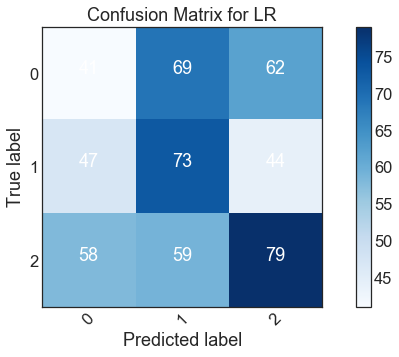

history_window: 2 year	 acc: 0.389


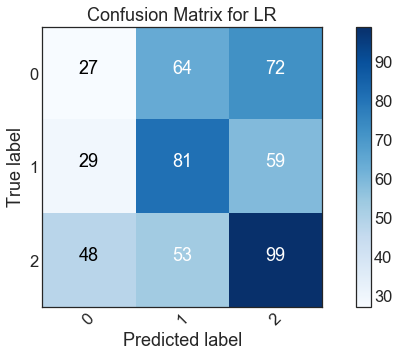

history_window: 3 year	 acc: 0.336


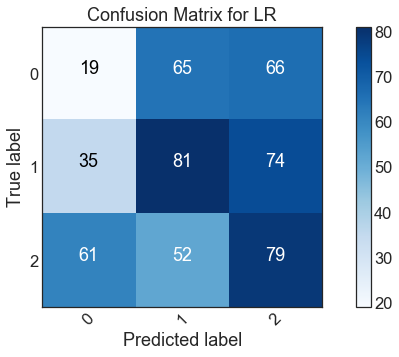

history_window: 4 year	 acc: 0.382


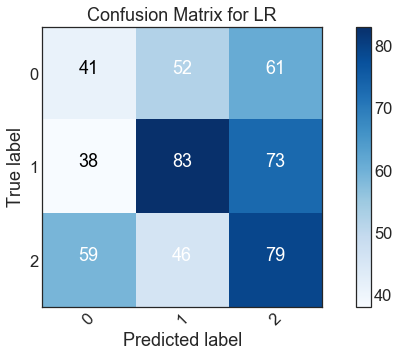

history_window: 5 year	 acc: 0.327


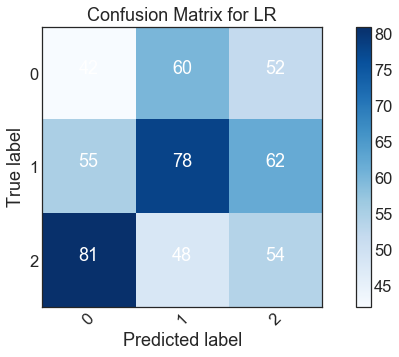

history_window: 6 year	 acc: 0.350


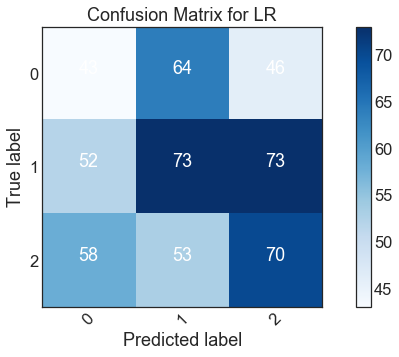

history_window: 7 year	 acc: 0.378


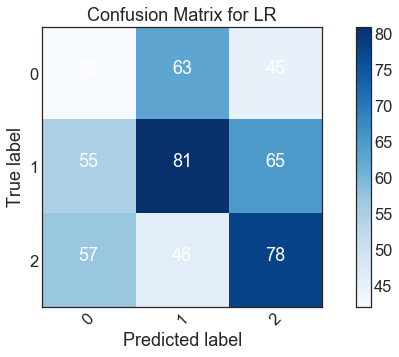

history_window: 8 year	 acc: 0.367


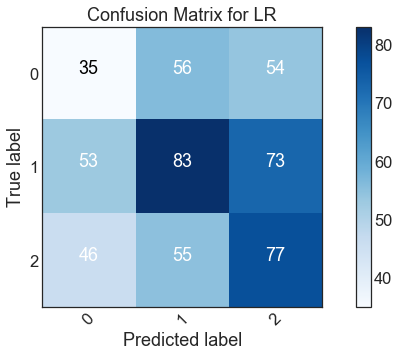

history_window: 9 year	 acc: 0.370


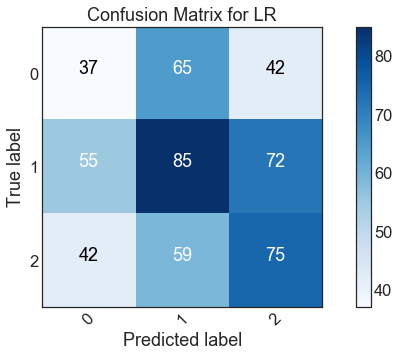

history_window: 10 year	 acc: 0.391


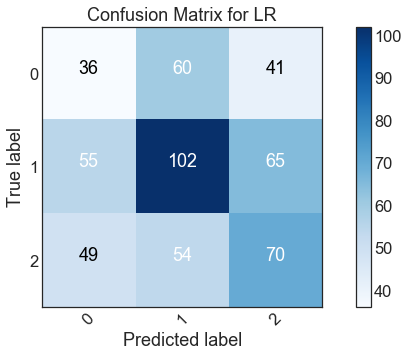

history_window: 11 year	 acc: 0.378


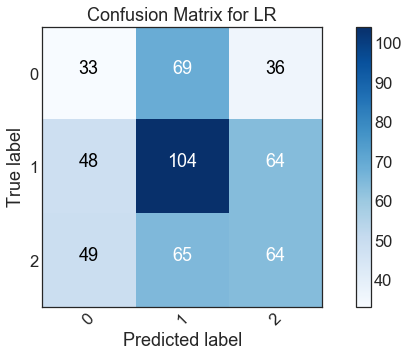

history_window: 12 year	 acc: 0.374


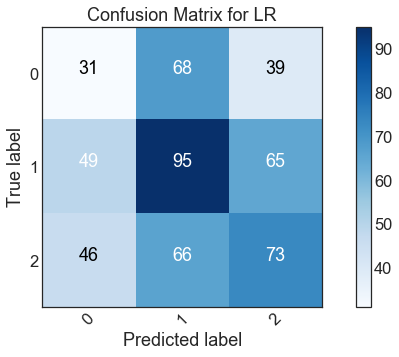

history_window: 13 year	 acc: 0.393


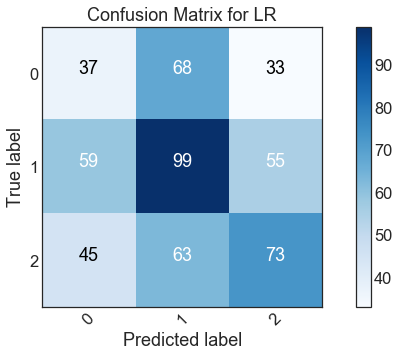

history_window: 14 year	 acc: 0.397


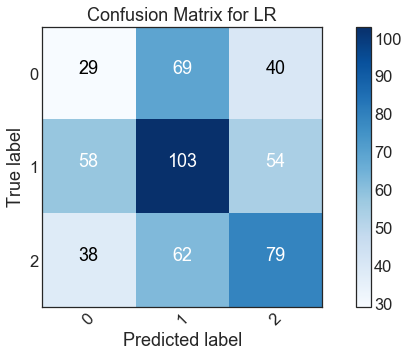

history_window: 15 year	 acc: 0.367


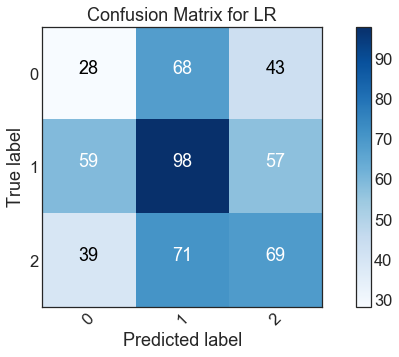

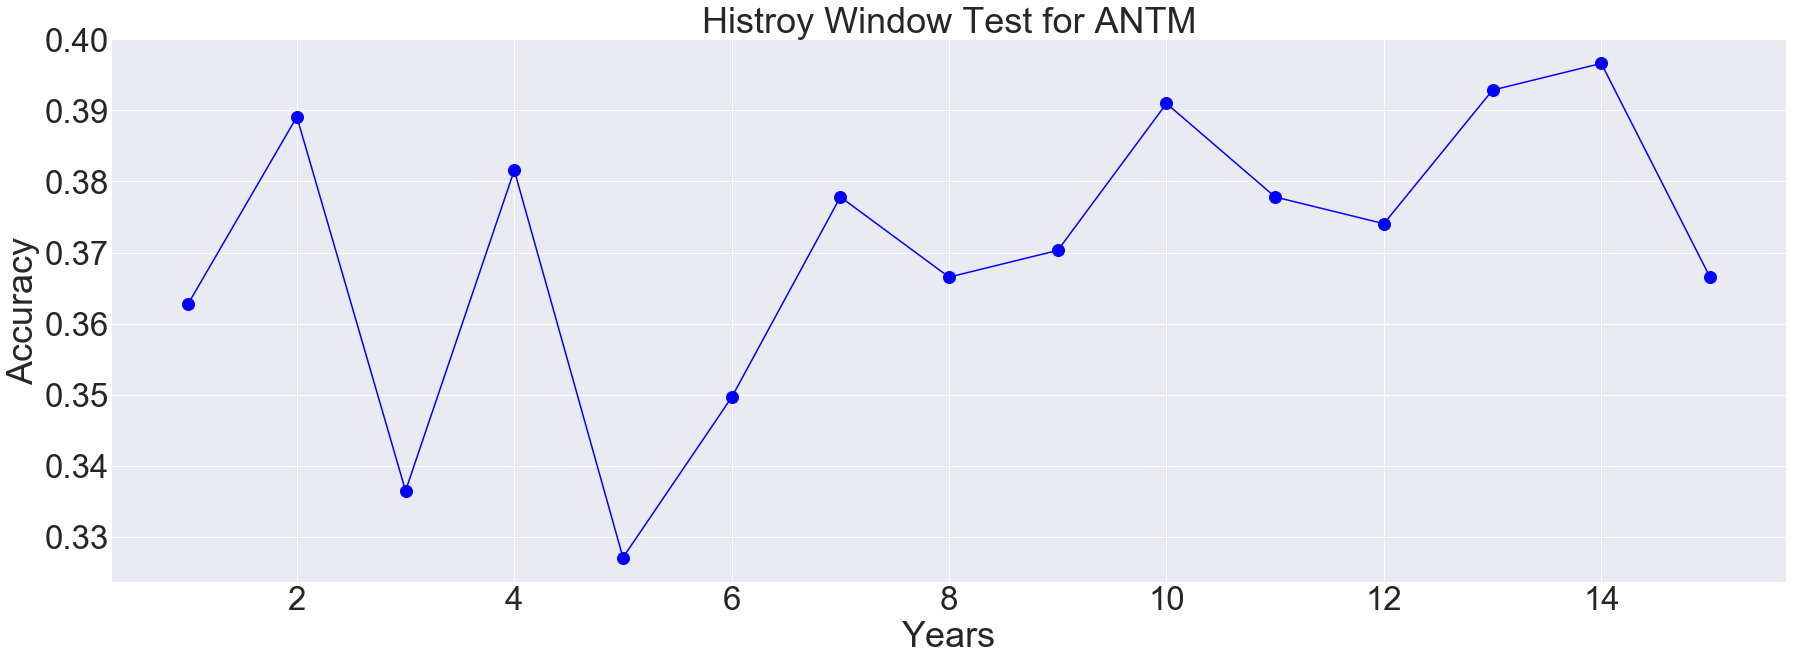

In [16]:
start_date = datetime.datetime(2003, 1, 2)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "ANTM"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
MODEL_NAME = 'LR'

ANTM_tech_df = generate_NDayReturn(selected_ANTM_tech_factors, ticker_name, start_date, end_date, pred_day)


def history_window_test(tech_df, test_date_start, model_name):
    history_windows = list(range(1, 16))
    accuracies = []
    
    for hw in history_windows:
        history_window = relativedelta(years=hw) # training history window 
        y_true, y_pred, test_dates =model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        accuracy = accuracy_score(y_true, y_pred)
        print('history_window: {h} year\t acc: {a:.3f}'.format(h=hw, a=accuracy))
        accuracies.append(accuracy)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(model_name))
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(history_windows, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Histroy Window Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Years')
    plt.show()

history_window_test(ANTM_tech_df, test_date_start, MODEL_NAME) 

### **Rolliing Window Test for Price Trends for ANTM**

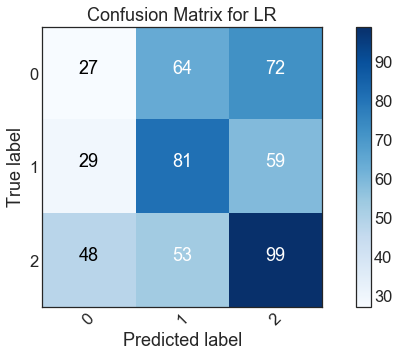

One-Week Daily Price Trend 	 acc: 0.389


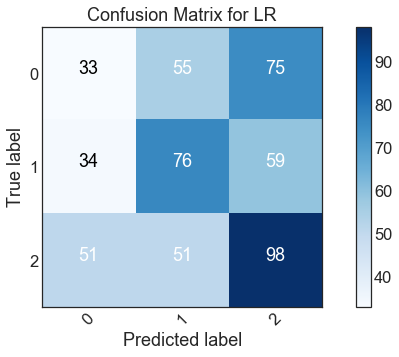

One-Month Daily Price Trend 	 acc: 0.389


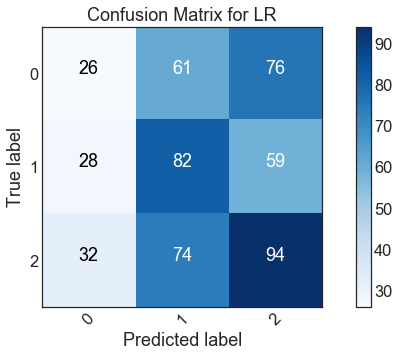

Three-Month Daily Price Trend 	 acc: 0.380


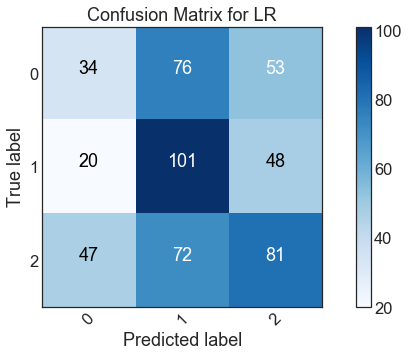

Nine-Month Daily Price Trend 	 acc: 0.406


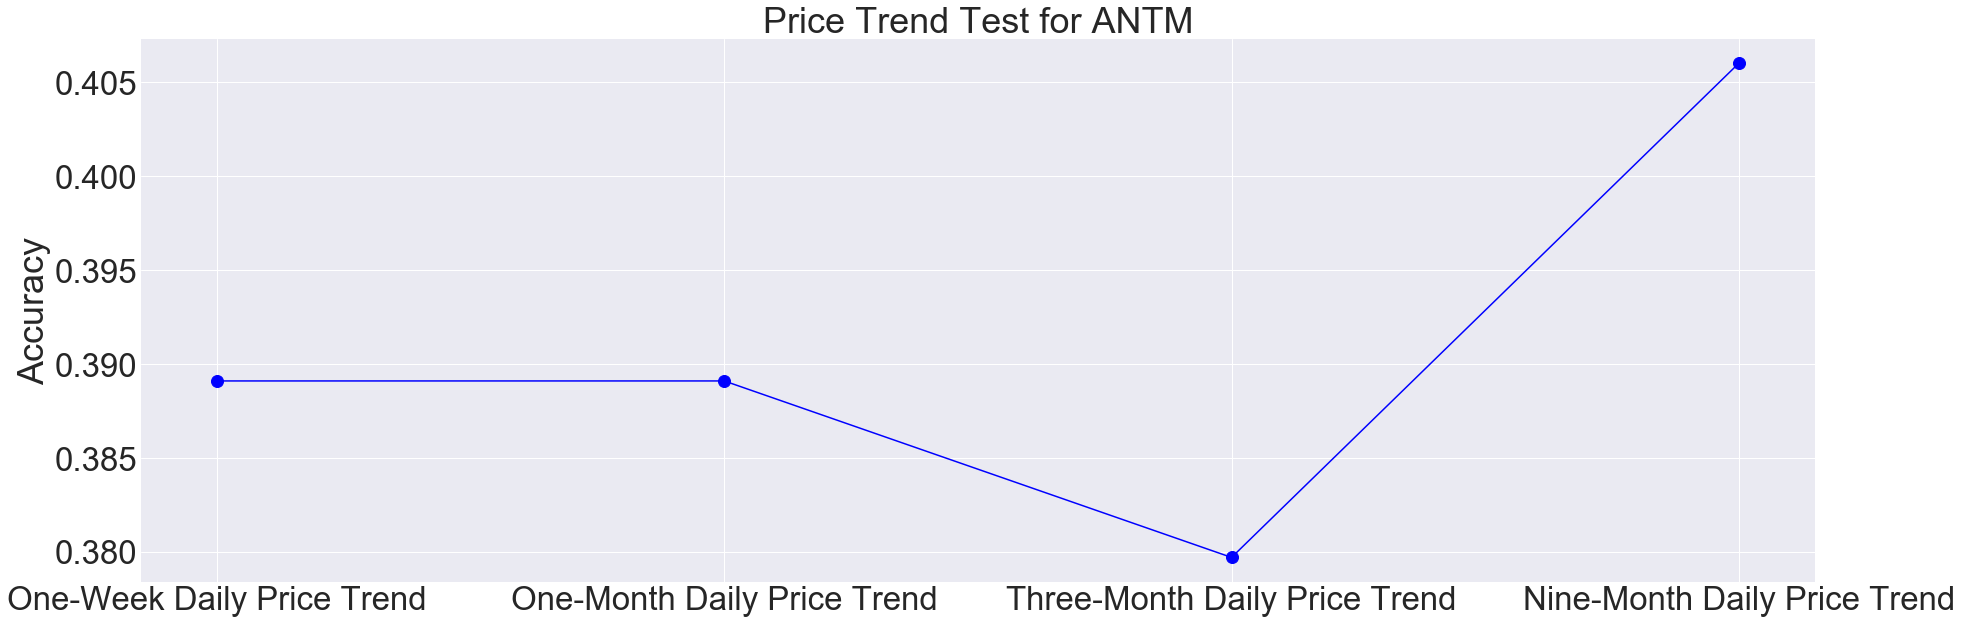

In [15]:
start_date = datetime.datetime(2003, 1, 2)
end_date = datetime.datetime(2019, 2, 28)
ticker_name = "ANTM"
pred_day = 5 # predict the future n days return 
test_date_start = datetime.datetime(2017, 1, 10) # testing start date
history_window = relativedelta(years=2) # training history window 
MODEL_NAME = 'LR'

def price_trend_test(tech_factor_df, test_date_start, model_name):
    price_trend = ['One-Week Daily Price Trend', 'One-Month Daily Price Trend', 'Three-Month Daily Price Trend', 'Nine-Month Daily Price Trend']
    accuracies = []
    
    for pt in price_trend: 
        selected_tech_factors = tech_factor_df[[pt, 'Relative Strength Index', 'MACD Signal', 
                                                    'Technical Indicator', 'One-Month Change in Average Daily Share Turnover', 
                                                      'Daily Media Sentiment Indicator']]
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pred_day)
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pred_day, model_name)
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {}'.format(model_name))
        accuracy = accuracy_score(y_true, y_pred)
        print('{p} \t acc: {a:.3f}'.format(p=pt, a=accuracy))
        accuracies.append(accuracy)
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(price_trend, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Price Trend Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
#     plt.xlabel('Days')
    plt.show()

price_trend_test(ANTM_tech_factor_df, test_date_start, MODEL_NAME) 

### **Predict Day Test for ANTM**

predict day: 1 days	 acc: 0.360


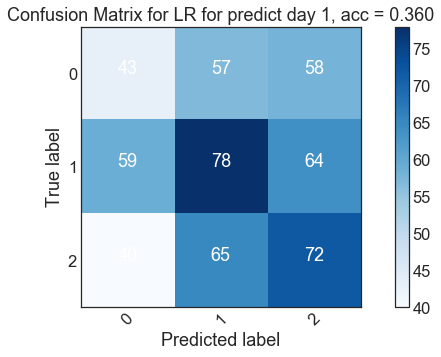

predict day: 2 days	 acc: 0.368


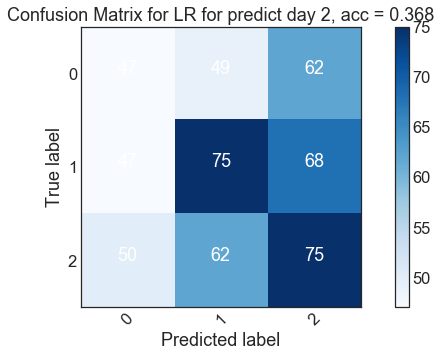

predict day: 3 days	 acc: 0.365


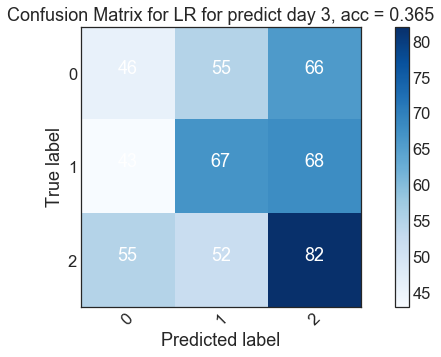

predict day: 4 days	 acc: 0.340


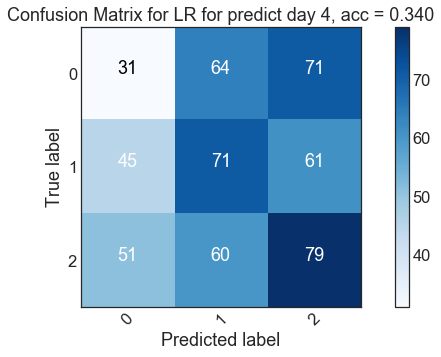

predict day: 5 days	 acc: 0.391


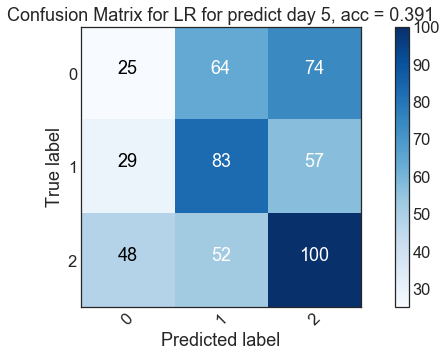

predict day: 6 days	 acc: 0.382


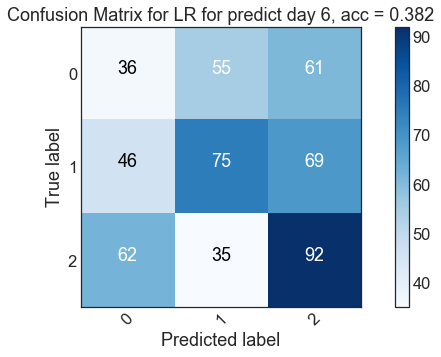

predict day: 7 days	 acc: 0.381


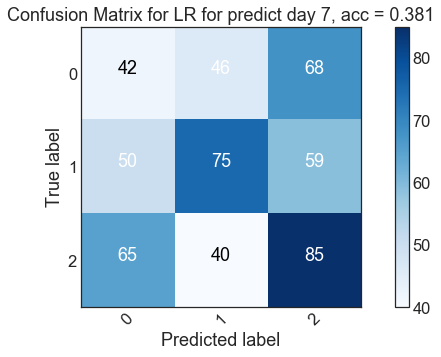

predict day: 8 days	 acc: 0.380


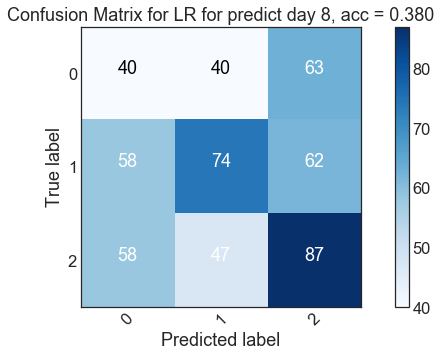

predict day: 9 days	 acc: 0.367


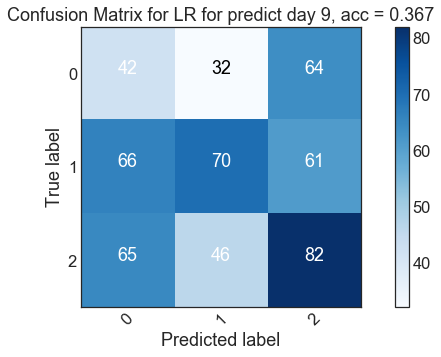

predict day: 10 days	 acc: 0.345


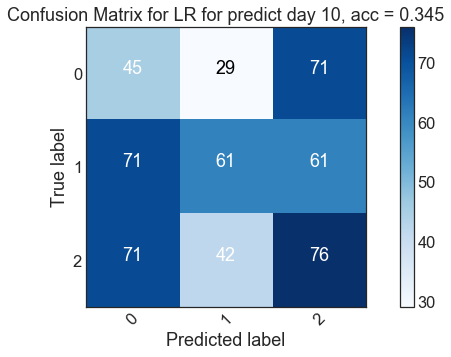

predict day: 15 days	 acc: 0.368


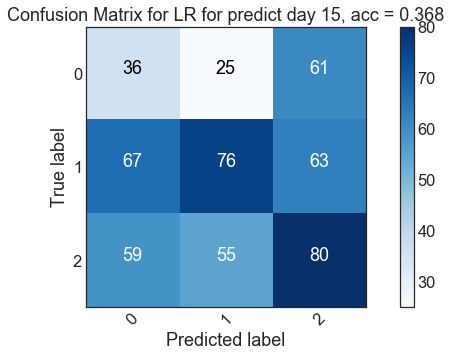

predict day: 20 days	 acc: 0.369


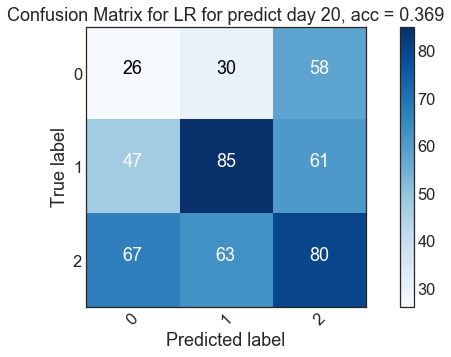

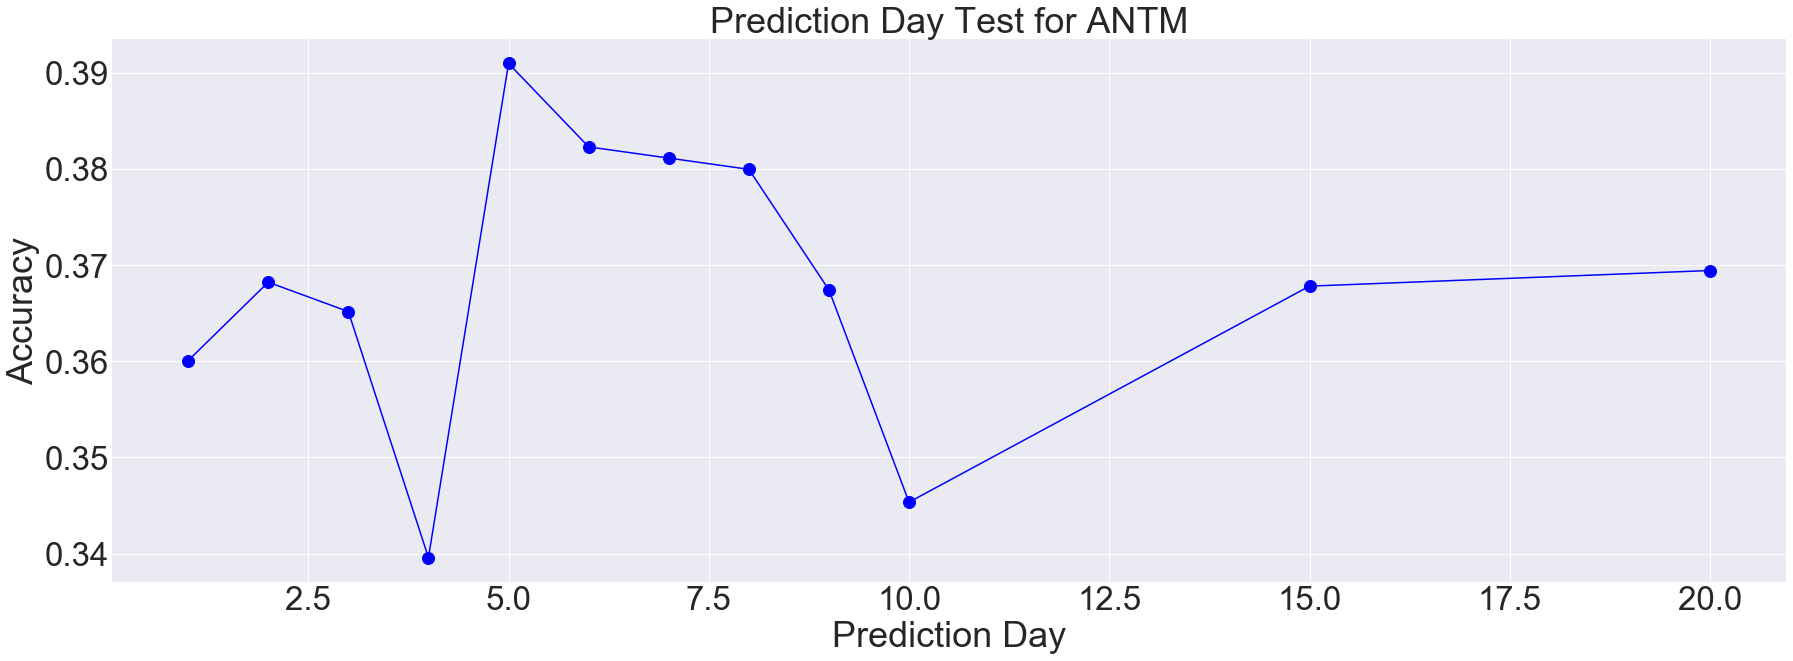

In [29]:
history_window = relativedelta(years=2) # training history window 

def prediction_day_thresholds_test(selected_tech_factors, model_name):
    pred_days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    accuracies = []                           
    for pd in pred_days: 
        tech_df = generate_NDayReturn(selected_tech_factors, ticker_name, start_date, end_date, pd)    
        y_true, y_pred, test_dates = model_testing(tech_df, test_date_start, history_window, pd, model_name)
        accuracy = accuracy_score(y_true, y_pred) 
        print('predict day: {p} days\t acc: {a:.3f}'.format(p=pd, a=accuracy))
        cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, 'Confusion Matrix for {n} for predict day {p}, acc = {a:.3f}'.format(n=model_name, p=pd, a=accuracy ))
        accuracies.append(accuracy)
    
    plt.rcParams['figure.figsize'] = (30, 10)
    sns.set_context('notebook', font_scale=3.0)
    plt.style.use('seaborn-darkgrid')
    plt.plot(pred_days, accuracies, linestyle='-', marker='o', markersize=12, color='blue')
    plt.title('Prediction Day Test for {}'.format(ticker_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Prediction Day')
    plt.show()

prediction_day_thresholds_test(selected_ANTM_tech_factors, MODEL_NAME)